# Segmantic Segmentation with VGG16

The initial attempt with using a GAN hit a wall, specifically with figuring out how to do proper layer sizing for the transposed convolution layers for the generator. On top of that, some research I did during my "off" time showed that the approach semantic segmentation using either an FCN (Fully Convolutional Network) approach or SegNet would work best.

Since SegNet is completely new, whereas transfer learning with VGG16 is something I'm familiar with, I'm going to attempt a VGG16 network here.

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from random import randint
from glob import glob
import os
import os.path
import scipy

%matplotlib inline

import tensorflow as tf
#Check GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
print('TensorFlow Version: {}'.format(tf.__version__))

Default GPU Device: /device:GPU:0
TensorFlow Version: 1.6.0


In [3]:
#useful variables
num_classes = 13 # none and 12 options, 0-12
image_shape = (160, 576)
# image_shape = (576, 160)
weights_initializer_stddev = 0.01
weights_regularized_l2 = 1e-3

## Load VGG16


First we're going to load VGG16 with pretrained weights (so it maintains its feature detectors, which can be useful for our smaller dataset).

In [4]:
#Download VGG16 if it is not already
from urllib.request import urlretrieve
import zipfile

if not os.path.exists("vgg16.zip"):
    urlretrieve(
        'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/vgg.zip',
        "./vgg16.zip")
    print("Downloaded VGG16 model weights")
else:
    print("Already exists, skipping download")

Already exists, skipping download


In [5]:
#Extract if needed
if not os.path.exists("./vgg"):
    unzip = zipfile.ZipFile("./vgg16.zip", "r")
    unzip.extractall("./")
    unzip.close()
    print("Extracted VGG16 model weights")
else:
    print("Already exists, skipping extraction")

Already exists, skipping extraction


### Helper Functions

First a couple of helper functions. Our output is an array of as any dimensions as we have classes - 13 by default, 3 for the given challenge.

The data comes in with all data on the red channel - 0-12 for the given class. I need to be able to return this format as well, so I have to convert from this image format to the multi-dimensional array - and vice versa.

In [6]:
#Make a map more colorful
def convertToColor(value):
    colors = [
        (255, 255, 255),   #0
        (255, 0, 0),      #1
        (0, 255, 0),      #2
        (0, 0, 255),      #3
        (255, 255, 0),    #4
        (127, 0, 255),    #5
        (51, 255, 51),    #6
        (255, 0, 127),    #7
        (127, 127, 127),  #8
        (0, 0, 0),        #9
        (0, 255, 255),  #10
        (0, 0, 100),      #11
        (100, 0, 0),      #12
    ]
    return colors[value[0]]

def colorizeMap(img):
    return [list( map(convertToColor, row) ) for row in img]

In [7]:
#We need to be able to convert the image map to a 13 channel ground truth map, and vice versa
def pixelToTruth(value):
    truths = [
        (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)
    ]
    
    return truths[value[0]]

def truthToPixel(value):
    return (value.tolist().index(1), 0, 0)

def imageToTruth(img):
    return [list(map(pixelToTruth, row)) for row in img]

def truthToImage(truth):
    return [list(map(truthToPixel, row)) for row in truth]

The below creates a batch iterator for us for training

In [8]:
# Function to load the image data and the label for it
def get_training_data(batch_size):
    #Both inputs and ground truth maps have the same name - easy!
    image_paths = glob(os.path.join("./data/Train/CameraRGB", "*.png"))
    label_paths = glob(os.path.join("./data/Train/CameraSeg", "*.png"))
    
    for batch in range(0, len(image_paths), batch_size):
        images = []
        maps = []
    
    for batch in range(0, len(image_paths), batch_size):
        images = []
        maps = []
        
        for index, image_file in enumerate(image_paths[batch:batch + batch_size]):
            map_file = os.path.join(label_paths[index])
            
            image = scipy.misc.imread(image_file)
            image = scipy.misc.imresize(image, image_shape)
#             image = image - np.array([123.68, 116.779, 103.939], dtype=np.float32)
            map_image = scipy.misc.imread(map_file)
            map_image = scipy.misc.imresize(map_image, image_shape)
            map_image = imageToTruth(map_image)
            
            images.append(image)
            maps.append(map_image)

        yield np.array(images), np.array(maps)
            
            

We're going to use the `model` object to keep track of each layer of our deep net for easy reference and debugging.

In [9]:
#Deep learning model
model = {}

Generate placeholders

In [24]:
def get_placeholders(model):
    model['placeholders'] = {}
    
    #Placeholders
    model['placeholders']['label'] = tf.placeholder(tf.int32, (None, image_shape[0], image_shape[1], model['settings']['num_classes']), name='label')
    model['placeholders']['learning_rate'] = tf.placeholder(tf.float32, name='learning_rate')

Load the VGG and pull out key aspects (keep_prob) andlayers (input, layers 3, 4, and 7)

In [11]:
def load_vgg(model):
    #Grab layers from pretrained VGG
    tf.saved_model.loader.load(sess, ["vgg16"], "./vgg/")
    
    model['graph'] = tf.get_default_graph()
    
    #define key layers for us to work with, so we can take pieces of VGG16
    #for our own use
    model['input_layer'] = model['graph'].get_tensor_by_name("image_input:0")
    model['keep_prob'] = model['graph'].get_tensor_by_name("keep_prob:0") #Dropout settings
    
    #more layer grabbing
    model['layer_3'] = model['graph'].get_tensor_by_name("layer3_out:0")
    model['layer_4'] = model['graph'].get_tensor_by_name("layer4_out:0")
    model['layer_7'] = model['graph'].get_tensor_by_name("layer7_out:0")

Build the FCN off of the VGG

In [22]:
def vgg_fcn(model):
    # Skip connections for later
    model['skip_conv_3'] = tf.layers.conv2d(model['layer_3'], model['settings']['num_classes'], 1, padding='same',
            kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
            kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2))
    
    model['skip_conv_4'] = tf.layers.conv2d(model['layer_4'], model['settings']['num_classes'], 1, padding='same',
            kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
            kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2))
    
    #Layer 7 isn't skipped, it's passed right to transpose    
    model['fully_connected_convs'] = tf.layers.conv2d(model['layer_7'], model['settings']['num_classes'], 1, padding='same',
            kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
            kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2))
    
    #From layer 7 we need to transpose up
    model['transpose_1'] = tf.layers.conv2d_transpose(model['fully_connected_convs'], model['settings']['num_classes'], 4, 2, padding='same',
            kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
            kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2))
    
    # Add the skip layer from layer 4
    model['skip_1'] = tf.add(model['transpose_1'], model['skip_conv_4'])
    
    #Tranpose up from resultant layer
    model['transpose_2'] = tf.layers.conv2d_transpose(model['skip_1'], model['settings']['num_classes'], 4, 2, padding='same',
            kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
            kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2))
    
    #Create skip layer from layer 3
    model['skip_2'] = tf.add(model['skip_conv_3'], model['transpose_2'])
    
    #Final output layer
    model['output_layer'] = tf.layers.conv2d_transpose(model['skip_2'], model['settings']['num_classes'], 16, 8, padding='same',
            kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
            kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2),
            activation=tf.sigmoid)
    
    return model['output_layer']

In [23]:
def vgg_fcn(model):
    # Skip connections for later
    model['skip_conv_3'] = tf.layers.conv2d(model['layer_3'], model['settings']['num_classes'], 1, padding='same')
    
    model['skip_conv_4'] = tf.layers.conv2d(model['layer_4'], model['settings']['num_classes'], 1, padding='same')
    
    #Layer 7 isn't skipped, it's passed right to transpose    
    model['fully_connected_convs'] = tf.layers.conv2d(model['layer_7'], model['settings']['num_classes'], 1, padding='same')
    
    #From layer 7 we need to transpose up
    model['transpose_1'] = tf.layers.conv2d_transpose(model['fully_connected_convs'], model['settings']['num_classes'], 4, 2, padding='same')
    
    # Add the skip layer from layer 4
    model['skip_1'] = tf.add(model['transpose_1'], model['skip_conv_4'])
    
    #Tranpose up from resultant layer
    model['transpose_2'] = tf.layers.conv2d_transpose(model['skip_1'], model['settings']['num_classes'], 4, 2, padding='same')
    
    #Create skip layer from layer 3
    model['skip_2'] = tf.add(model['skip_conv_3'], model['transpose_2'])
    
    #Final output layer
    model['output_layer'] = tf.layers.conv2d_transpose(model['skip_2'], model['settings']['num_classes'], 16, 8, padding='same', activation=tf.sigmoid)
    
    return model['output_layer']

Generate logits

In [21]:
def get_logits(model):
    model['logits'] = {}
    
    #Create the optimzer
    model['logits']['logits'] = tf.reshape(model['output_layer'], (-1, model['settings']['num_classes']))
    model['logits']['correct_label'] = tf.reshape(model['placeholders']['label'], (-1, model['settings']['num_classes']))

Create loss functions and training operation

In [29]:
def get_loss(model):
    model['loss'] = {}
    
    model['loss']['softmax'] = tf.nn.softmax_cross_entropy_with_logits_v2(logits=model['logits']['logits'], labels=model['logits']['correct_label'])
    model['loss']['cross_entropy_loss'] = tf.reduce_mean(model['loss']['softmax'])
    model['loss']['optimizer'] = tf.train.AdamOptimizer(learning_rate=model['placeholders']['learning_rate'])
    model['loss']['train_op'] = model['loss']['optimizer'].minimize(model['loss']['cross_entropy_loss'])

Model traning function

In [31]:
def train(sess, model, epochs=1, batch_size=10, keep_probability=0.5, learning_rate_alpha=0.001):
    
    saver = tf.train.Saver()
    
    sess.run(tf.global_variables_initializer())
    
    print("Graph has been built - launching training")
    print("====== :-) ======")
    print()
    
    for epoch in range(epochs):
        print("Launching Epoch {}".format(epoch))
        loss_log = []
        batch_count = 0
        
        #get the images
        for image, truth in get_training_data(batch_size):
            batch_count += 1
            _, loss = sess.run(
                    [model['loss']['train_op'], model['loss']['cross_entropy_loss']],
                    feed_dict = {
                        model['input_layer']: image,
                        model['placeholders']['label']: truth,
                        model['keep_prob']: keep_probability,
                        model['placeholders']['learning_rate']: learning_rate_alpha
                    }
                )
            loss_log.append('{:3f}'.format(loss))
            if(batch_count % 10 == 0):
                print("Batch {} - loss of {}".format(batch_count, loss))
        print("Training for epoch finished - ", loss_log[-1])
        chkpt_path = "./chkpts/model_epoch_{}.ckpt".format(epoch)
        saver.save(sess, chkpt_path)
        print("Model saved as {}".format(chkpt_path))
        print()
    print("Training finished")

Combine the above functions for building our net and use them below to run the net and train it.

Note that as of this run, we're using 13 classes, whereas our actual network uses 3. This is really just to see if it trains decently well and what our output is like. I'll only run 10 epochs. and see what I can get

In [33]:
tf.reset_default_graph()
with tf.Session() as sess:
    
    model = {}
    model['settings'] = { "num_classes": 13 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
 
    train(sess, model, 10, 5, 0.75, 0.0001)
  

INFO:tensorflow:Restoring parameters from b'./vgg/variables/variables'
Graph has been built - launching training
====== :-) ======

Launching Epoch 0


/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Batch 10 - loss of 2.5196614265441895
Batch 20 - loss of 2.4093995094299316
Batch 30 - loss of 2.318009614944458
Batch 40 - loss of 2.2749087810516357
Batch 50 - loss of 2.23948335647583
Batch 60 - loss of 2.211486577987671
Batch 70 - loss of 2.192931890487671
Batch 80 - loss of 2.1779415607452393
Batch 90 - loss of 2.167819023132324
Batch 100 - loss of 2.1632285118103027
Batch 110 - loss of 2.158043146133423
Batch 120 - loss of 2.151967763900757
Batch 130 - loss of 2.142294406890869
Batch 140 - loss of 2.137542247772217
Batch 150 - loss of 2.1324615478515625
Batch 160 - loss of 2.12631893157959
Batch 170 - loss of 2.1288297176361084
Batch 180 - loss of 2.1275577545166016
Batch 190 - loss of 2.1198513507843018
Batch 200 - loss of 2.1163132190704346
Training for epoch finished -  2.116313
Model saved as ./chkpts/model_epoch_0.ckpt

Launching Epoch 1
Batch 10 - loss of 2.115309000015259
Batch 20 - loss of 2.1116161346435547
Batch 30 - loss of 2.1056838035583496
Batch 40 - loss of 2.10084

Batch 120 - loss of 1.9145445823669434
Batch 130 - loss of 1.9152504205703735
Batch 140 - loss of 1.9137307405471802
Batch 150 - loss of 1.913623332977295
Batch 160 - loss of 1.9130363464355469
Batch 170 - loss of 1.9127124547958374
Batch 180 - loss of 1.9123023748397827
Batch 190 - loss of 1.9113293886184692
Batch 200 - loss of 1.910696029663086
Training for epoch finished -  1.910696
Model saved as ./chkpts/model_epoch_9.ckpt

Training finished


After training above, we don't have great results, but let's see what the network is doing.

I didn't expect great results - given the very tiny size of the dataset and the number of classes we have to define, I'd expect poor results. This is mostly to ensure we don't have any oddities in training and the network architecture *can* learn, and that our output looks even somewhat "correct".

In [51]:
def execute_on_image(sess, model):

    chosen_image = "165"
    image_file = "./data/Train/CameraRGB/{}.png".format(chosen_image)
    truth_file = "./data/Train/CameraSeg/{}.png".format(chosen_image)
    
    image = scipy.misc.imread(image_file)
    image = scipy.misc.imresize(image, image_shape)
    plt.figure()
    plt.imshow(image)
    
    truth = scipy.misc.imread(truth_file)
    truth = scipy.misc.imresize(truth, image_shape)
    plt.figure()
    plt.imshow(truth)
    truth = imageToTruth(truth)
    
    return sess.run([model['output_layer']], feed_dict={
            model['input_layer']: image,
            model['placeholders']['label']: truth,
            model['keep_prob']: .9,
            model['placeholders']['learning_rate']: 0.01
        })

INFO:tensorflow:Restoring parameters from ./chkpts/model_epoch_9.ckpt


/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  del sys.

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("image_input:0", shape=(?, ?, ?, 3), dtype=float32) is not an element of this graph.

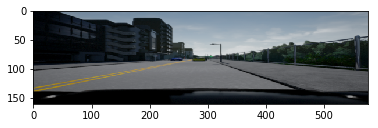

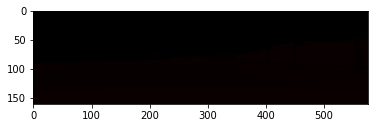

In [52]:
tf.reset_default_graph()
with tf.Session() as sess:
    saver = tf.train.import_meta_graph("./chkpts/model_epoch_9.ckpt.meta")
    saver.restore(sess, tf.train.latest_checkpoint('./chkpts/'))
    
    results = execute_on_image(sess, model)